In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm import tqdm

from models import TextClassificationModel, zip_ssl
from datasets import AGNEWS
from utils import train, eval, pearson, acc, nomean, pearson_delta

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
EPOCHS = 20
LR = 1e-2
BATCH_SIZE = 2048
EMBED_DIM = 64

In [4]:
ds = AGNEWS()

In [5]:
# train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE)
# model = TextClassificationModel(embed_dim = EMBED_DIM).to(device)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = LR)

In [6]:
# log = []
# for epoch in tqdm(range(EPOCHS)):
#     loss_train = train(model, train_loader, criterion, optimizer)
#     loss_eval = eval(model, val_loader, criterion)
#     # print(loss_train, loss_eval)
#     log.append([loss_train, loss_eval])
# plt.plot(log);
# eval(model, test_loader, criterion), acc(model, test_loader)

In [7]:
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl = True)
model = zip_ssl(embed_dim = EMBED_DIM).to(device)

# criterion = pearson
# criterion = nomean
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LR)

In [9]:
log = []
for epoch in tqdm(range(EPOCHS)):
    loss_train = train(model, train_loader, criterion, optimizer, ssl = True)
    loss_eval = eval(model, val_loader, criterion, ssl = True)
    corr = eval(model, val_loader, pearson_delta, ssl = True)
    print(loss_train, loss_eval, corr)
    log.append([loss_train, loss_eval])

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:08<02:48,  8.87s/it]

9.179523361748772e-06 8.076591106752555e-06 0.00011250262707471847


 10%|█         | 2/20 [00:17<02:39,  8.84s/it]

6.853213925894938e-06 8.676785199592511e-06 9.443734089533487e-05


 15%|█▌        | 3/20 [00:26<02:29,  8.81s/it]

5.035405635441604e-06 7.784152558694283e-06 7.706959545612335e-05


 20%|██        | 4/20 [00:35<02:20,  8.80s/it]

5.619124819835027e-06 8.555883076041936e-06 7.569883018732071e-05


 25%|██▌       | 5/20 [00:44<02:11,  8.79s/it]

4.7360858267271205e-06 7.32041181375583e-06 3.791647776961327e-05


 30%|███       | 6/20 [00:52<02:03,  8.80s/it]

4.02226673618874e-06 6.911248279114564e-06 2.6509595414002736e-05


 35%|███▌      | 7/20 [01:01<01:54,  8.77s/it]

3.8456658285372616e-06 7.503869788100322e-06 5.313999330004056e-05


 40%|████      | 8/20 [01:10<01:45,  8.75s/it]

3.7662760934612732e-06 7.327606901526451e-06 7.835760712623596e-05


 45%|████▌     | 9/20 [01:18<01:36,  8.74s/it]

3.080326508273158e-06 6.943974643945694e-06 3.125666454434395e-05


 50%|█████     | 10/20 [01:27<01:27,  8.74s/it]

3.486884604698341e-06 7.2356658056378365e-06 2.318908181041479e-05


 55%|█████▌    | 11/20 [01:36<01:18,  8.75s/it]

3.2691883838229013e-06 6.4966116721431415e-06 3.46055335054795e-05


 60%|██████    | 12/20 [01:45<01:09,  8.74s/it]

3.5365526380605604e-06 7.1927872486412525e-06 3.101716625193755e-05


 65%|██████▌   | 13/20 [01:53<01:01,  8.73s/it]

3.444747161937126e-06 8.224702750643095e-06 4.302056382099788e-05


 70%|███████   | 14/20 [02:02<00:52,  8.73s/it]

3.26137996703517e-06 9.18636688341697e-06 4.290144455929597e-05


 75%|███████▌  | 15/20 [02:11<00:43,  8.73s/it]

2.9949905134312676e-06 7.6057901605963705e-06 2.1408239379525183e-05


 80%|████████  | 16/20 [02:20<00:34,  8.73s/it]

2.8694146823366745e-06 1.0059707798063755e-05 3.9568433227638406e-05


 85%|████████▌ | 17/20 [02:28<00:26,  8.75s/it]

3.1153868941034663e-06 6.656242224077384e-06 3.656527524193128e-05


 90%|█████████ | 18/20 [02:37<00:17,  8.75s/it]

3.1274671956341255e-06 7.848869388302167e-06 2.7216349417964616e-05


 95%|█████████▌| 19/20 [02:46<00:08,  8.74s/it]

2.9602640761846773e-06 7.211339970429739e-06 4.1519350682695705e-05


100%|██████████| 20/20 [02:55<00:00,  8.76s/it]

2.9061636581134638e-06 7.626505413403114e-06 4.365766855577628e-05


(8.218096275078623e-06, 3.018899967795924e-05)

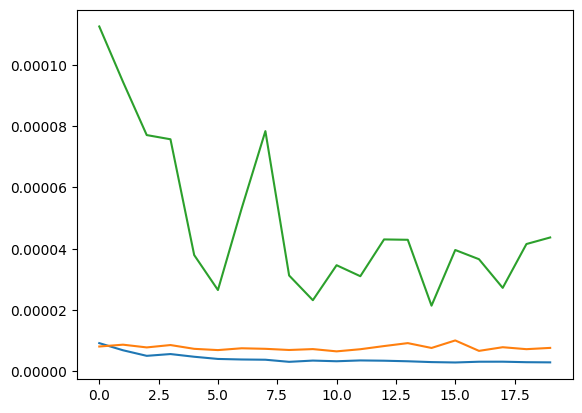

In [21]:
plt.plot(log);
eval(model, test_loader, criterion, ssl = True), eval(model, test_loader, pearson_delta, ssl = True)
# eval(model, test_loader, criterion, ssl = True)

In [18]:
for idx, (label, text, offsets) in enumerate(val_loader):
    btsz = len(offsets) // 2
    h = model.forward(text, offsets)
    delta = torch.nn.functional.pairwise_distance(h[:btsz], h[btsz:])
    loss = criterion(delta, label)
    break

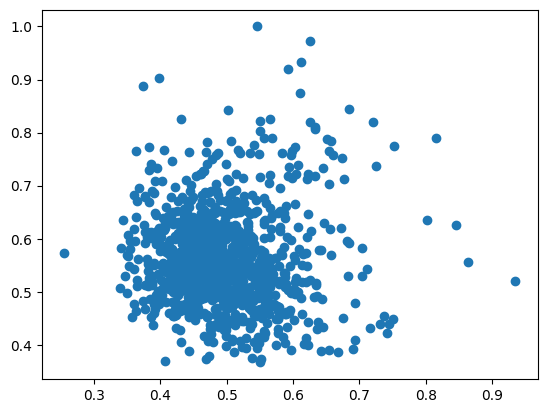

In [19]:
plt.scatter(delta.cpu().detach(), label.cpu().detach())